# A Fully Connected Deep Learning Network to Determine Cancer Tumor Variety Given Patient Gene Expression

- Link to Data set: https://archive.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq
- The dataset contains data from 801 patients and gene expression levels of 20,531 genes.
- Patients have one of five tumors in this dataset: Breast invasive carcinoma (BRCA), Kidney renal clear cell carcinoma (KIRC), Colon adenocarcinoma (COAD), Lung adenocarcinoma (LUAD), and Prostate adenocarcinoma (PRAD).
- The goal is to classify the patient by which tumor they have given their gene expression levels.
- Much of this code has been adapted from Mike X Cohen's "A Deep Understanding of Deep Learning" course.


In [ ]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

# for printing out status reports
import sys

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset,TensorDataset
from google.colab import drive,files

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-372c9e844a7b>:22: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Upload the Data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 # Upload the Data
data_file_path = '/content/drive/MyDrive/coding_project/data.csv'
data_df = pd.read_csv(data_file_path)

labels_file_path = '/content/drive/MyDrive/coding_project/labels.csv'
column_names = ["Samples","Cancer Type"]
labels_df = pd.read_csv(labels_file_path,names=column_names)




# Exploring the data

In [ ]:
print("The Data:")
print(data_df)
print("\n","\n")
print("The Labels:")
print(labels_df)

The Data:
     Unnamed: 0  gene_0    gene_1    gene_2    gene_3     gene_4  gene_5  \
0      sample_0     0.0  2.017209  3.265527  5.478487  10.431999     0.0   
1      sample_1     0.0  0.592732  1.588421  7.586157   9.623011     0.0   
2      sample_2     0.0  3.511759  4.327199  6.881787   9.870730     0.0   
3      sample_3     0.0  3.663618  4.507649  6.659068  10.196184     0.0   
4      sample_4     0.0  2.655741  2.821547  6.539454   9.738265     0.0   
..          ...     ...       ...       ...       ...        ...     ...   
796  sample_796     0.0  1.865642  2.718197  7.350099  10.006003     0.0   
797  sample_797     0.0  3.942955  4.453807  6.346597  10.056868     0.0   
798  sample_798     0.0  3.249582  3.707492  8.185901   9.504082     0.0   
799  sample_799     0.0  2.590339  2.787976  7.318624   9.987136     0.0   
800  sample_800     0.0  2.325242  3.805932  6.530246   9.560367     0.0   

       gene_6    gene_7  gene_8  ...  gene_20521  gene_20522  gene_20523  \
0

In [ ]:
# Clean the data, dropping unecessary columns and rows
clean_data_df=data_df.drop(data_df.columns[0],axis=1)
clean_labels_df=labels_df.drop(labels_df.columns[0],axis=1)
clean_labels_df=labels_df.drop(clean_labels_df.index[0])
clean_labels_df.dropna(inplace=True)
clean_labels_df=clean_labels_df.reset_index(drop=True)
clean_data_df.dropna(inplace=True)
print(clean_data_df)
print("\n","\n")
print(clean_labels_df)

     gene_0    gene_1    gene_2    gene_3     gene_4  gene_5    gene_6  \
0       0.0  2.017209  3.265527  5.478487  10.431999     0.0  7.175175   
1       0.0  0.592732  1.588421  7.586157   9.623011     0.0  6.816049   
2       0.0  3.511759  4.327199  6.881787   9.870730     0.0  6.972130   
3       0.0  3.663618  4.507649  6.659068  10.196184     0.0  7.843375   
4       0.0  2.655741  2.821547  6.539454   9.738265     0.0  6.566967   
..      ...       ...       ...       ...        ...     ...       ...   
796     0.0  1.865642  2.718197  7.350099  10.006003     0.0  6.764792   
797     0.0  3.942955  4.453807  6.346597  10.056868     0.0  7.320331   
798     0.0  3.249582  3.707492  8.185901   9.504082     0.0  7.536589   
799     0.0  2.590339  2.787976  7.318624   9.987136     0.0  9.213464   
800     0.0  2.325242  3.805932  6.530246   9.560367     0.0  7.957027   

       gene_7  gene_8  gene_9  ...  gene_20521  gene_20522  gene_20523  \
0    0.591871     0.0     0.0  ...   

In [ ]:
# View range and stats of the data
print("Dataset Max:", clean_data_df.max(axis=1).max(), "\nDataset Min:",clean_data_df.min(axis=1).min(),"\nDataset Mean:",clean_data_df.values.mean(),"\nDataset Standard Dev:",clean_data_df.values.std())

Dataset Max: 20.7788287118 
Dataset Min: 0.0 
Dataset Mean: 6.443322266573226 
Dataset Standard Dev: 4.05819368383075


In [ ]:
# Normalize Data to between 0 and 1
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(clean_data_df), columns=clean_data_df.columns)

# Check to see if normalization worked
print("Dataset Max:", data_normalized.max(axis=1).max(), "\nDataset Min:",data_normalized.min(axis=1).min(),"\nDataset Mean:",data_normalized.values.mean(),"\nDataset Standard Dev:",data_normalized.values.std())

Dataset Max: 1.0000000000000004 
Dataset Min: 0.0 
Dataset Mean: 0.4076195537797761 
Dataset Standard Dev: 0.24990362490204374


# Prepare data for Deep Learning


In [ ]:
# One hot encode labels
labels_encoded = pd.get_dummies(clean_labels_df, columns=["Cancer Type"])
print(labels_encoded)

        Samples  Cancer Type_BRCA  Cancer Type_COAD  Cancer Type_KIRC  \
0      sample_0                 0                 0                 0   
1      sample_1                 0                 0                 0   
2      sample_2                 0                 0                 0   
3      sample_3                 0                 0                 0   
4      sample_4                 1                 0                 0   
..          ...               ...               ...               ...   
796  sample_796                 1                 0                 0   
797  sample_797                 0                 0                 0   
798  sample_798                 0                 1                 0   
799  sample_799                 0                 0                 0   
800  sample_800                 0                 0                 0   

     Cancer Type_LUAD  Cancer Type_PRAD  
0                   0                 1  
1                   1                 0

In [ ]:
# Convert from dataframe to Tensor

dataT  = torch.tensor(data_normalized.values).float()
labelsT = torch.tensor(labels_encoded.iloc[:, 1:].values).float()
print(dataT.shape)
print(labelsT.shape)

torch.Size([801, 20531])
torch.Size([801, 5])


In [ ]:
# use scikitlearn to split the data into train and devtest sets
train_data,devtest_data, train_labels,devtest_labels = train_test_split(dataT, labelsT, test_size=.2)

# Split into devset and test set
dev_data,test_data, dev_labels,test_labels = train_test_split(devtest_data, devtest_labels, test_size=.5)

# Convert to pytorch datasets
trainset = TensorDataset(train_data,train_labels)
devset  = TensorDataset(dev_data,dev_labels)
testset  = TensorDataset(test_data,test_labels)

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=len(devset))
test_loader  = DataLoader(testset, batch_size=len(testset))



In [ ]:
# Ensure data load is the correct shape
X,y=next(iter(train_loader))
print(X.shape)


torch.Size([32, 20531])


# Now for the Deep Learning


In [ ]:
# create a class for the model
def makeTheNet():

  class theNet(nn.Module):
    def __init__(self):
      super().__init__()

      #parameters
      #self.dr = .2 #This parameter controls the dropout rate

      ### input layer
      self.input = nn.Linear(20531,5000)

      ### hidden layers
      self.fc1 = nn.Linear(5000,1000)
      self.bnorm1 = nn.BatchNorm1d(5000)
      self.fc2 = nn.Linear(1000,100)
      self.bnorm2 = nn.BatchNorm1d(1000)
      self.fc3 = nn.Linear(100,10)
      self.bnorm3 = nn.BatchNorm1d(100)

      ### output layer
      self.output = nn.Linear(10,5)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      #x = F.dropout(x,p=self.dr,training=self.training) #implement dropout
      x = self.bnorm1(x) #batch norm
      x = F.relu( self.fc1(x) )
     # x = F.dropout(x,p=self.dr,training=self.training)
      x = self.bnorm2(x)
      x = F.relu( self.fc2(x) )
      #x = F.dropout(x,p=self.dr,training=self.training)
      x = self.bnorm3(x)
      x = F.relu( self.fc3(x) )
      return self.output(x)

  # create the model instance
  net = theNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer

In [ ]:
# test the model on some data
net,lossfun,opto=makeTheNet()

X,y=next(iter(train_loader))
yHat=net(X)
print(X.shape)
print(yHat.shape)

torch.Size([32, 20531])
torch.Size([32, 5])


In [ ]:
# Create a function that trains the model
def function2trainTheModel(L1lambda):

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # number of epochs
  numepochs = 25

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  devAcc   = []

  # count the total number of weights in the model
  nweights = 0
  for pname,weight in net.named_parameters():
    if 'bias' not in pname:
      nweights = nweights + weight.numel()


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []

    for X,y in train_loader:
      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      ### add L1 term
      L1_term = torch.tensor(0.,requires_grad=True)

      # sum up all abs(weights)
      for pname,weight in net.named_parameters():
        if 'bias' not in pname:
           L1_term = L1_term + torch.sum(torch.abs(weight))

      # add to loss term
      #print("before loss",loss)
      loss = loss + L1lambda*L1_term/nweights
      #print("after loss",loss)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch

      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == torch.argmax(y,axis=1)     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      accuracyPct=accuracyPct.cpu()
      batchAcc.append( accuracyPct )               # add to list of accuracies
      #end of batch loop

    # now that we've trained through the batches, get their average training accuracy

    trainAcc.append( np.mean(batchAcc) )


    # and get average losses across the batches

    losses[epochi] = np.mean(batchLoss)

    # dev accuracy
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from dev dataloader
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # append to dev acc
    devAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==torch.argmax(y,axis=1)).float()).cpu() )
    msg = f'Finished epoch {epochi+1}/{numepochs}'
    sys.stdout.write('\r' + msg)
  # end epochs

  # function output
  return trainAcc,devAcc,losses,net

# An experiment to check the effect of L1Lambda Value on the distribution of weights in the trained network
- I'd like to create a relatively sparse network that learns the most important features very well.
- This may be helpful as I attempt to determine which features are the most important.



In [ ]:
# This function takes a smaller random sample of the weights. This smaller random sample will be used for plotting.
def getSubSample(weights,num_samples):
  # Generate random indices
  random_indices = torch.randperm(weights.size(0))[:num_samples]

  # Use the indices to sample data points from the tensor
  sampled_data = weights[random_indices]
  return sampled_data

In [ ]:
# This function returns some stats about all of the weights in the model

def getWeightStats(net):
  # Access the state_dict of the model
  model_state_dict = net.state_dict()

  weights=torch.tensor([])

  # Count the number of zeros in the weights
  zero_count = 0
  for param_name, param_tensor in model_state_dict.items():
    if 'weight' in param_name and "bnorm" not in param_name:  # Check if the parameter is a weight

      #Create a tensor that contains all weights
      temp_weight = param_tensor.flatten()
      weights=torch.cat((weights,temp_weight))

      # Get the weights that are very close to zero
      mask = (-0.00001 < param_tensor) & (param_tensor < 0.00001)
      zero_count += torch.sum(mask).item()

  max_weights = torch.max(weights)
  min_weights = torch.min(weights)
  mean_weights = torch.mean(weights)
  std_weights = torch.std(weights)

  return max_weights,min_weights,mean_weights,std_weights,zero_count,weights


In [ ]:
lambda_list = [.00001,.001,.01,1,10,100]

results_df = pd.DataFrame(columns=["L1Lambda","Number of Zeros", "Weights Min", "Weights Max", "Weights StDev", "Weights Mean", "Train Accuracy", "Dev Accuracy"])
weights_df = pd.DataFrame(columns=["L1Lambda","Weights Subset"])
for L1lambda in lambda_list:

  # Train the network with specified lambda value
  trainAcc,devAcc,losses,net = function2trainTheModel(L1lambda)
  net.cpu()

  # Get weight stats
  max_weights,min_weights,mean_weights,std_weights,zero_count,weights = getWeightStats(net)

  # Subsample weights
  sampled_weights = getSubSample(weights,5000)

  # Organize stats and weights into proper columns
  new_row_stats = {"L1Lambda": L1lambda, "Number of Zeros": zero_count, "Weights Min": min_weights,\
             "Weights Max": max_weights, "Weights StDev": std_weights, "Weights Mean": mean_weights,\
             "Train Accuracy": trainAcc[-1], "Dev Accuracy": devAcc[-1]}
  new_row_weights = {"L1Lambda": L1lambda, "Weights Subset": sampled_weights}

  #Append results to respective dataframes
  results_df=results_df.append(new_row_stats, ignore_index=True)
  weights_df=weights_df.append(new_row_weights, ignore_index=True)







Finished epoch 25/25

<ipython-input-19-15dc86c39417>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(new_row_stats, ignore_index=True)
<ipython-input-19-15dc86c39417>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights_df=weights_df.append(new_row_weights, ignore_index=True)


Finished epoch 25/25

<ipython-input-19-15dc86c39417>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(new_row_stats, ignore_index=True)
<ipython-input-19-15dc86c39417>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights_df=weights_df.append(new_row_weights, ignore_index=True)


Finished epoch 25/25

<ipython-input-19-15dc86c39417>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(new_row_stats, ignore_index=True)
<ipython-input-19-15dc86c39417>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights_df=weights_df.append(new_row_weights, ignore_index=True)


Finished epoch 25/25

<ipython-input-19-15dc86c39417>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(new_row_stats, ignore_index=True)
<ipython-input-19-15dc86c39417>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights_df=weights_df.append(new_row_weights, ignore_index=True)


Finished epoch 25/25

<ipython-input-19-15dc86c39417>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(new_row_stats, ignore_index=True)
<ipython-input-19-15dc86c39417>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights_df=weights_df.append(new_row_weights, ignore_index=True)


Finished epoch 25/25

<ipython-input-19-15dc86c39417>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(new_row_stats, ignore_index=True)
<ipython-input-19-15dc86c39417>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights_df=weights_df.append(new_row_weights, ignore_index=True)


In [ ]:
# Examine weight stats
print(results_df)

    L1Lambda Number of Zeros      Weights Min     Weights Max   Weights StDev  \
0    0.00001         4653105  tensor(-0.3910)  tensor(0.4393)  tensor(0.0069)   
1    0.00100         4506321  tensor(-0.3346)  tensor(0.4383)  tensor(0.0065)   
2    0.01000         4448367  tensor(-0.3673)  tensor(0.4239)  tensor(0.0076)   
3    1.00000         2289143  tensor(-0.3718)  tensor(0.4486)  tensor(0.0063)   
4   10.00000         7049039  tensor(-0.3563)  tensor(0.4031)  tensor(0.0067)   
5  100.00000        17280403  tensor(-0.3731)  tensor(0.4051)  tensor(0.0058)   

          Weights Mean  Train Accuracy  Dev Accuracy  
0      tensor(-0.0001)         99.6875  tensor(100.)  
1  tensor(-6.9312e-05)        100.0000  tensor(100.)  
2      tensor(-0.0002)         99.3750  tensor(100.)  
3   tensor(2.2758e-06)        100.0000  tensor(100.)  
4  tensor(-8.6508e-05)        100.0000  tensor(100.)  
5  tensor(-5.2957e-05)         99.6875  tensor(100.)  


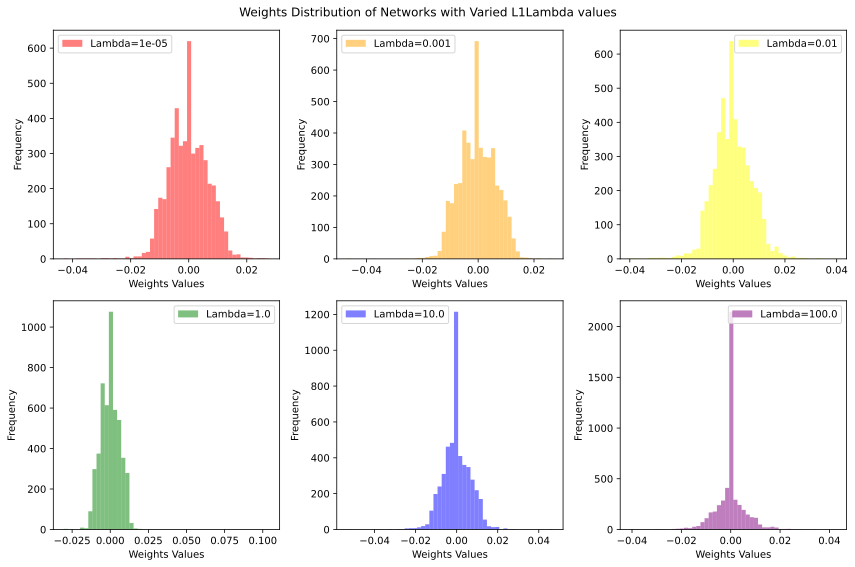

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].hist(weights_df.loc[0,'Weights Subset'], bins=50, alpha=0.5, label=f"Lambda={weights_df.loc[0,'L1Lambda']}", color='red')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Weights Values')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(weights_df.loc[1,'Weights Subset'], bins=50, alpha=0.5, label=f"Lambda={weights_df.loc[1,'L1Lambda']}", color='orange')
axs[0, 1].legend()
axs[0, 1].set_xlabel('Weights Values')
axs[0, 1].set_ylabel('Frequency')

axs[0, 2].hist(weights_df.loc[2,'Weights Subset'], bins=50, alpha=0.5, label=f"Lambda={weights_df.loc[2,'L1Lambda']}", color='yellow')
axs[0, 2].legend()
axs[0, 2].set_xlabel('Weights Values')
axs[0, 2].set_ylabel('Frequency')

axs[1, 0].hist(weights_df.loc[3,'Weights Subset'], bins=50, alpha=0.5, label=f"Lambda={weights_df.loc[3,'L1Lambda']}", color='green')
axs[1, 0].legend()
axs[1, 0].set_xlabel('Weights Values')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(weights_df.loc[4,'Weights Subset'], bins=50, alpha=0.5, label=f"Lambda={weights_df.loc[4,'L1Lambda']}", color='blue')
axs[1, 1].legend()
axs[1, 1].set_xlabel('Weights Values')
axs[1, 1].set_ylabel('Frequency')

axs[1, 2].hist(weights_df.loc[5,'Weights Subset'], bins=50, alpha=0.5, label=f"Lambda={weights_df.loc[5,'L1Lambda']}", color='purple')
axs[1, 2].legend()
axs[1, 2].set_xlabel('Weights Values')
axs[1, 2].set_ylabel('Frequency')


plt.suptitle('Weights Distribution of Networks with Varied L1Lambda values')
plt.tight_layout()
plt.show()


- L1 regularization has a very small  effect on the distribution of our weights below a lambda value of 1.0.
- As lambda increases, weights cluster increasingly around 0.
- Train and dev accuracy largely isn't affected by lambda values investigated

# Estimate Feature Importance

I will investigate a couple of different ways to determine feature importance. I'd like to determine which genes have the greatest effect on classification in the network.
- Sum weights from input layer to first hidden layer per input neuron. The neurons with the highest sums of connection weights are not necessarily the most important, given that they are further transformed in the hidden layers. However, this is an interesting way to get at feature importance without any complex analysis. This may point to genes that should be further investigated.
- Methodically shuffle columns, and see which shuffled column has the biggest effect on network accuracy. This is computationally expensive.

In [ ]:
# retrain our model with our choice of L1 Lambda
trainAcc,devAcc,losses,net = function2trainTheModel(.01) #specify L1Lambda

Finished epoch 25/25

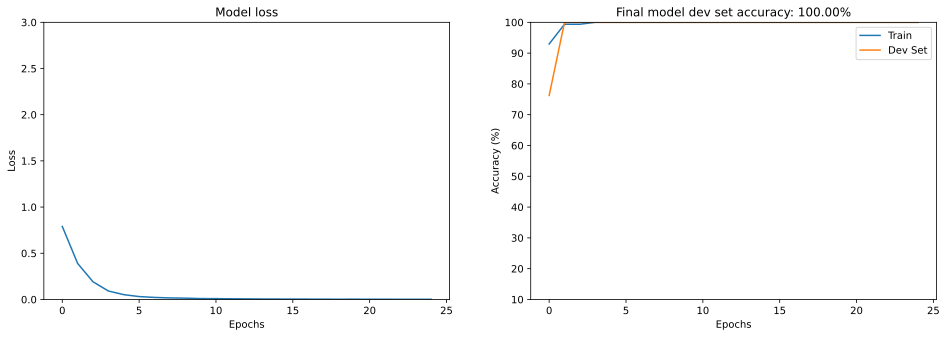

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(devAcc,label='Dev Set')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model dev set accuracy: {devAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# Check accuracy on test set
net.eval()
net.cpu()
X,y = next(iter(test_loader)) # extract X,y from test dataloader
with torch.no_grad(): # deactivates autograd
  yHat = net(X)

print("Test Set Accuracy:",100*torch.mean((torch.argmax(yHat,axis=1)==torch.argmax(y,axis=1)).float()) )

Test Set Accuracy: tensor(100.)


### Determine which features have the greatest weights in the first layer

In [ ]:
# Determine the sum of weights per input feature between input layer and hidden layer.

# Access the weights in the input layer of the model
weights = net.input.weight.data

# Sum along the dimension corresponding to the neuron
weights_sum = torch.sum(torch.abs(weights),dim=0)
max_weights, max_indices = torch.topk(weights_sum, k=1000, largest=True) # getting the 1000 features with the greatest weights
print(max_weights[:10])
# Print the genes that have the highest weights associated with them in the input layer
print(clean_data_df.columns[max_indices][:10])






tensor([28.1198, 28.0934, 27.8497, 27.8427, 27.7265, 27.6814, 27.6232, 27.5776,
        27.5553, 27.4533])
Index(['gene_17801', 'gene_8005', 'gene_7623', 'gene_8013', 'gene_19661',
       'gene_7964', 'gene_8004', 'gene_1317', 'gene_15613', 'gene_8031'],
      dtype='object')


### Does shuffling those features one by one affect the performance of the model?
- By randomizing the each feature one-by-one and testing the model accuracy, I hope to see a decrease in performance of the model associated with the most important features

In [ ]:
# A function to shuffle a column in our dataset

def colshuff(df,col_to_shuff):
  shuffled_values = np.random.permutation(df.iloc[:,col_to_shuff])
  new_df = df.copy()
  new_df.iloc[:,col_to_shuff] = shuffled_values
  return new_df


In [ ]:
col_counter = 1
accList=[]

for col in max_indices:
  col=int(col)

  # Shuffle a column in our normalized data df
  shuf_df = colshuff(data_normalized,col)

  # Package into data loader
  dataT_shuf  = torch.tensor(shuf_df.values).float()
  shuf_set = TensorDataset(dataT_shuf,labelsT)
  shuf_loader = DataLoader(shuf_set,  batch_size=len(shuf_set))

  # Apply trained network to our DL with shuffled column
  X,y=next(iter(shuf_loader))

  # Send data and net to GPU
  X = X.to(device)
  y = y.to(device)
  net.to(device)

  #Make sure net is in eval mode
  net.eval()

  with torch.no_grad(): # deactivates autograd
    yHat = net(X)
  acc = 100*torch.mean((torch.argmax(yHat,axis=1)==torch.argmax(y,axis=1)).float())
  acc = acc.cpu()
  accList.append(acc)

  msg = f'Finished Column {col_counter}/{len(max_indices)}'
  sys.stdout.write('\r' + msg)

  col_counter+=1


In [ ]:
print(min(accList))

tensor(100.)


### Analysis
- Even after individually shuffling the 1000 columns with the greatest weights and checking the accuracy of our network, our network was still accurate 100 percent of the time.
- I was hoping that shuffling some of the columns would reduce the accuracy of the network, thereby telling us which columns are the most important in classification

### Train the model multiple times and determine which feature, on average, has the greatest weights in the first layer


In [ ]:
times_to_train=30
all_weights_sum = torch.zeros(20531)

for i in range(times_to_train):

  # Train the model
  trainAcc,devAcc,losses,net = function2trainTheModel(.01)

  #get the weights between the input data and the first hidden layer
  net.cpu()
  weights = net.input.weight.data
  weights_sum = torch.sum(torch.abs(weights),dim=0)

  #add weights to all weights
  all_weights_sum+=weights_sum

avg_weights=all_weights_sum/times_to_train

# Find the largest avg weights and their indicies
max_avg_weights, max_avg_indices = torch.topk(avg_weights, k=10, largest=True)

# Print the largest average weights
print(max_avg_weights)

# Print the genes that have the highest weights associated with them in the input layer
print(clean_data_df.columns[max_avg_indices])


Finished epoch 25/25tensor([40.1580, 39.9164, 39.3119, 38.6956, 38.3971, 37.8675, 37.7375, 37.5454,
        37.3253, 37.2152])
Index(['gene_15895', 'gene_11903', 'gene_5578', 'gene_15898', 'gene_15896',
       'gene_7623', 'gene_17801', 'gene_7964', 'gene_2318', 'gene_11576'],
      dtype='object')


### Analysis:
- Now that we've determined which genes tended to be the most important in the first layer of this model, the next step would be to match the gene ID to the gene itself.
- Unfortunately, the information about which genes are associated with which gene IDs is not readily available.
- Consider this network to be more proof of concept: given gene expressions of patients, we are able to determine which type of tumor they have.
- Further work should investigate the biological importance of genes that are the most important in this classification network.
- Further work could also expand this network to include more tumor varieties, as well as include gene expression data from healthy patients.

## Brute Force Determination of Feature Importance
- The following code tests the network's accuracy by independently shuffling every feature and running the modified the data through the network.
- The feature, when shuffled, that yields the lowest network accuracy, should be the most important feature.
- When the features with the greatest weights were shuffled, there was no observed effect on accuracy, so this likely wouldn't yield any notable results.
- This is also computationally expensive and for that reason was not executed here.

In [ ]:
accList =[]
for col in range(data_normalized.shape[1]):

  # Shuffle a column in our normalized data df
  shuf_df = colshuff(data_normalized,col)

  # Package into data loader
  dataT_shuf  = torch.tensor(shuf_df.values).float()
  shuf_set = TensorDataset(dataT_shuf,labelsT)
  shuf_loader = DataLoader(shuf_set,  batch_size=len(shuf_set))

  # Apply trained network to our DL with shuffled column
  X,y=next(iter(shuf_loader))

  # Send data and net to GPU
  X = X.to(device)
  y = y.to(device)
  net.to(device)

  #Make sure net is in eval mode
  net.eval()

  with torch.no_grad(): # deactivates autograd
    yHat = net(X)
  acc = 100*torch.mean((torch.argmax(yHat,axis=1)==torch.argmax(y,axis=1)).float())
  acc = acc.cpu()
  accList.append(acc)
  msg = f'Finished Column {col+1}/{data_normalized.shape[1]}'
  sys.stdout.write('\r' + msg)



# Define the file path in Colab
file_path_colab = '/content/accList.txt'

# Open the file in write mode and write the list elements to the file
with open(file_path_colab, 'w') as file:
    for item in accList:
        file.write(f"{item}\n")

# Define the file path in Google Drive
file_path_drive = '/content/drive/MyDrive/coding_project/accList.txt'

# Copy the file from Colab to Google Drive
!cp $file_path_colab $file_path_drive

# Display the saved file path in Google Drive
print(f"List saved to Google Drive: {file_path_drive}")